In [16]:
# Global imports
import os
import numpy as np
import pandas as pd
import imageio
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import tensorflow_addons as tfa
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from sklearn.model_selection import KFold
import numpy as np
import os
import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, Flatten, Dense
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from tqdm import tqdm
import gc

In [17]:
# import tensorflow as tf
# import librosa
# #print(tf.config.list_physical_devices('GPU'))
# # Desactivar GPU y forzar uso de CPU
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         #tf.config.experimental.set_memory_growth(gpus[0], True)
#         pass
#     except RuntimeError as e:
#         print(e)

# #tf.config.set_visible_devices([], 'GPU')

In [18]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # TensorFlow 2.x
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
else:
    print("No GPU found")


1 Physical GPUs, 1 Logical GPUs


# Load dataset


In [19]:
import pickle
def load_data(filename):
    """
    Load data from a pickle file.

    Args:
        filename (str): The path to the pickle file.

    Returns:
        dict: The loaded data dictionary.
    """
    with open(filename, 'rb') as file:
        data_dict_loaded = pickle.load(file)
    return data_dict_loaded

filename = "../Data/D3TEC.pkl"
data_dict_loaded = load_data(filename)
# data_dict_loaded

In [20]:
data_dict_loaded[3]

{'Marca temporal': '2023/10/11 1:57:08 p.\xa0m. GMT-6',
 'PHQ-9 Score': 3,
 'Age': 62,
 'Gender': 'Female',
 'Lugar de Residencia': 'San Pedro, Nuevo León',
 'Lugar de Procedencia': nan,
 'Social Class': 'Upper Class',
 'Institution': 'CAABI',
 'Medicine': 'Sertrialina',
 'Physical Condition': 'Estenosis Espinal',
 'Mental Health Condition': 'Ansiedad',
 'Depression Diagnosis (level)': nan,
 'PHQ-Binary': 0,
 'audios': {'sm': {0: {'file_path': 'D:/Github/Improving-deep-neural-networks-to-identify-mental-disorders-using-Neural-Architecture-Search/D3T3C/D3TEC Dataset/SM-27\\153.wav',
    'waveform': array([-3.4575351e-07, -3.7821010e-06, -4.8473012e-06, ...,
           -7.4757336e-06, -4.6938076e-06, -1.4753023e-06], dtype=float32),
    'sample_rate': 22050,
    'spectrogram': array([[-41.41863 , -35.586212, -42.963806, ..., -50.34841 , -42.829468,
            -59.43257 ],
           [-42.578403, -34.543472, -38.21392 , ..., -37.266647, -38.4431  ,
            -47.42988 ],
           [-4

In [21]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, LeakyReLU, Flatten, Dense, Input, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import KFold
import datetime
import json
from tqdm import tqdm
import librosa
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import gc
import psutil

# Deshabilitar XLA compilación
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'

# Variable global para rastrear si la función ya se ha llamado
first_call = True

def specificity(y_true, y_pred):
    true_negatives = tf.reduce_sum(tf.cast((y_pred < 0.5) & (y_true == 0), tf.float32))
    possible_negatives = tf.reduce_sum(tf.cast(y_true == 0, tf.float32))
    specificity = true_negatives / (possible_negatives + tf.keras.backend.epsilon())
    return specificity

def log_memory_usage(stage):
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    print(f"[{stage}] Memory usage: {memory_info.rss / (1024 ** 2):.2f} MB")

class KFoldCNNTester:
    def __init__(self, data_dict, filename, batch_size=1, use_dummy_data=False, use_tf_data=True, use_complete_model=False, num_channels=3):
        self.data_dict = data_dict
        self.filename = filename
        self.batch_size = batch_size
        self.mean_acc_per_fold = []
        self.mean_loss_per_fold = []
        self.mean_precision_per_fold = []
        self.mean_recall_per_fold = []
        self.mean_auc_per_fold = []
        self.mean_specificity_per_fold = []
        self.kfold_list = []
        self.state_file = f'{self.filename}_state.json'
        self.keys = list(data_dict.keys())  # Lista de keys del diccionario
        self.use_dummy_data = use_dummy_data
        self.use_tf_data = use_tf_data  # Flag para elegir el método de generación de datos
        self.use_complete_model = use_complete_model  # Flag para usar el modelo completo
        self.num_channels = num_channels  # Número de canales para las imágenes

    def save_state(self, fold_no, epoch_no, num_folds):
        state = {'fold_no': fold_no, 'epoch_no': epoch_no, 'num_folds': num_folds}
        with open(self.state_file, 'w') as f:
            json.dump(state, f)

    def load_state(self):
        if os.path.exists(self.state_file):
            with open(self.state_file, 'r') as f:
                state = json.load(f)
            return state['fold_no'], state['epoch_no'], state['num_folds']
        return 1, 0, None

    def run_kfold_test(self):
        start_fold, start_epoch, start_num_folds = self.load_state()
        num_folds_range = [5, 8, 10] # range(3, 11)
        
        for num_folds in num_folds_range:
            if start_num_folds is not None and num_folds < start_num_folds:
                continue

            acc_per_fold = []
            loss_per_fold = []
            precision_per_fold = []
            recall_per_fold = []
            auc_per_fold = []
            specificity_per_fold = []

            no_epochs = 100
            verbosity = 2
            kfold = KFold(n_splits=num_folds, shuffle=True)

            fold_no = 1

            for train_indices, test_indices in kfold.split(range(len(self.data_dict))):
                if num_folds == start_num_folds and fold_no < start_fold:
                    fold_no += 1
                    continue

                # Obtener las keys correspondientes a los índices
                train_keys = [self.keys[i] for i in train_indices]
                test_keys = [self.keys[i] for i in test_indices]

                model = self.define_model()

                checkpoint_filepath_1 = f'{self.filename}_checkpoint_{num_folds}_fold_{fold_no}_1.h5'
                checkpoint_filepath_2 = f'{self.filename}_checkpoint_{num_folds}_fold_{fold_no}_2.h5'

                def try_load_weights():
                    try:
                        # Crear el modelo con un lote de datos para inicializar las variables
                        X_dummy, _ = self.generate_batch_data([train_keys[0]])
                        model(X_dummy)  # Pasa datos dummy a través del modelo para inicializar las variables
                        model.load_weights(checkpoint_filepath_1)
                    except Exception as e:
                        print(f"Error loading {checkpoint_filepath_1}: {e}")
                        try:
                            model.load_weights(checkpoint_filepath_2)
                        except Exception as e:
                            print(f"Error loading {checkpoint_filepath_2}: {e}")
                
                try_load_weights()

                print('------------------------------------------------------------------------')
                print(f'Training for fold {fold_no} of {num_folds} folds...')

                checkpoint_callback_1 = ModelCheckpoint(filepath=checkpoint_filepath_1, save_weights_only=True,
                                                        monitor='loss', mode='min', save_best_only=False)

                checkpoint_callback_2 = ModelCheckpoint(filepath=checkpoint_filepath_2, save_weights_only=True,
                                                        monitor='loss', mode='min', save_best_only=False)

                callback = EarlyStopping(monitor='loss', patience=3, min_delta=0.0001)

                if self.use_tf_data:
                    train_dataset = self.create_dataset(train_keys)
                    for epoch in range(start_epoch, no_epochs):
                        steps_per_epoch = np.ceil(len(train_keys) / self.batch_size).astype(int)
                        print(f"Training epoch {epoch+1}/{no_epochs}, steps per epoch: {steps_per_epoch}")
                        model.fit(train_dataset, epochs=1, verbose=verbosity, callbacks=[checkpoint_callback_1], steps_per_epoch=steps_per_epoch)
                        # Guardar el segundo checkpoint al finalizar la época
                        model.save_weights(checkpoint_filepath_2)
                        self.save_state(fold_no, epoch + 1, num_folds)
                        log_memory_usage(f"Epoch {epoch+1} End")
                        start_epoch = 0  # Reset start_epoch after the first epoch in this loop
                else:
                    steps_per_epoch = np.ceil(len(train_keys) / self.batch_size).astype(int)
                    for epoch in range(start_epoch, no_epochs):
                        print(f"Training epoch {epoch+1}/{no_epochs}, steps per epoch: {steps_per_epoch}")
                        for i in tqdm(range(0, len(train_keys), self.batch_size), desc=f"Training fold {fold_no}, epoch {epoch+1}"):
                            batch_keys = train_keys[i:i + self.batch_size]
                            X_train, y_train = self.generate_batch_data(batch_keys)
                            model.fit(X_train, y_train, batch_size=self.batch_size, epochs=1, verbose=verbosity, callbacks=[checkpoint_callback_1])
                            del X_train, y_train  # Eliminar datos del lote para liberar memoria
                            gc.collect()  # Recolector de basura explícito para liberar memoria
                        # Guardar el segundo checkpoint al finalizar la época
                        model.save_weights(checkpoint_filepath_2)
                        self.save_state(fold_no, epoch + 1, num_folds)
                        log_memory_usage(f"Epoch {epoch+1} End")
                        start_epoch = 0  # Reset start_epoch after the first epoch in this loop

                # Reset start_epoch for the next fold
                start_epoch = 0

                if self.use_tf_data:
                    test_dataset = self.create_dataset(test_keys)
                    steps_per_epoch = np.ceil(len(test_keys) / self.batch_size).astype(int)
                    print(f"Evaluating fold {fold_no}, steps per epoch: {steps_per_epoch}")
                    scores = model.evaluate(test_dataset, verbose=0, steps=steps_per_epoch)
                else:
                    scores = []
                    for i in tqdm(range(0, len(test_keys), self.batch_size), desc=f"Evaluating fold {fold_no}"):
                        batch_keys = test_keys[i:i + self.batch_size]
                        X_test, y_test = self.generate_batch_data(batch_keys)
                        score = model.evaluate(X_test, y_test, verbose=0)
                        scores.append(score)
                        del X_test, y_test  # Eliminar datos del lote para liberar memoria
                        gc.collect()  # Recolector de basura explícito para liberar memoria
                    scores = np.mean(scores, axis=0)

                acc_per_fold.append(scores[1] * 100)
                loss_per_fold.append(scores[0])
                precision_per_fold.append(scores[2])
                recall_per_fold.append(scores[3])
                auc_per_fold.append(scores[4])
                specificity_per_fold.append(scores[5])

                print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]}: {scores[2]}; {model.metrics_names[3]}: {scores[3]}; {model.metrics_names[4]}: {scores[4]}; {model.metrics_names[5]}: {scores[5]}')

                if scores[1] * 100 > 60:
                    self.save_model_and_data(model, fold_no, scores, num_folds, train_keys)

                self.save_state(fold_no + 1, 0, num_folds)  # Guardar el estado después de completar cada fold
                fold_no += 1

            self.calculate_means(acc_per_fold, loss_per_fold, precision_per_fold, recall_per_fold, auc_per_fold, specificity_per_fold, num_folds)

    def generate_batch_data(self, batch_keys):
        if self.use_dummy_data:
            X = np.random.rand(self.batch_size, 252, 792, self.num_channels)  # Datos dummy
            y = np.random.randint(0, 2, self.batch_size)  # Etiquetas dummy
        else:
            X = []
            y = []
            for key in batch_keys:
                info = self.data_dict[key]
                for audio_type, audios in info['audios'].items():
                    for question_number, audio_data in audios.items():
                        if isinstance(question_number, int) and audio_type == "sm":  # Ensure it is a question number
                            spectrogram = audio_data['mel_spectrogram']
                            spectrogram_image = self.generate_image_from_spectrogram(spectrogram)
                            X.append(spectrogram_image)
                            y.append(info['PHQ-Binary'])
            X = np.array(X)
            y = np.array(y)
            X = X / 255.0  # Normalize the images
        return X, y

    def define_model(self):
        if self.use_complete_model:
            return self.define_complete_model()
        else:
            model = Sequential([
                BatchNormalization(name='batch_normalization_9'),
                Conv2D(16, kernel_size=(3, 3), padding='same', name='conv2d_6'),  # Reducir el número de filtros
                LeakyReLU(alpha=0.01, name='leaky_re_lu_9'),
                BatchNormalization(name='batch_normalization_10'),
                Conv2D(8, (3, 3), padding='same', name='conv2d_7'),
                LeakyReLU(alpha=0.01, name='leaky_re_lu_10'),
                BatchNormalization(name='batch_normalization_11'),
                Flatten(name='flatten_6'),
                Dense(32, name='dense_6'),  # Reducir el número de neuronas
                LeakyReLU(alpha=0.01, name='leaky_re_lu_11'),
                Dense(1, activation='sigmoid', name='dense_7')
            ])
            model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), specificity])
            return model

    def define_complete_model(self):
        input_shape = (252, 792, self.num_channels)
        inputs = Input(shape=input_shape)

        x = Conv2D(32, kernel_size=(3, 3), padding='same')(inputs)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.01)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

        for _ in range(31):
            x = Conv2D(32, kernel_size=(3, 3), padding='same')(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(alpha=0.01)(x)

        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.5)(x)

        outputs = Dense(1, activation='sigmoid')(x)

        model = Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), specificity])
        return model

    def save_model_and_data(self, model, fold_no, scores, num_folds, train_keys):
        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        folder_path = f'{self.filename}_{current_time}/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        subfolder_path = folder_path + f'{num_folds}-fold_{fold_no}-{scores[1]*100}/'
        if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)

        model.save(subfolder_path + f'fold-{fold_no}.h5')

    def calculate_means(self, acc_per_fold, loss_per_fold, precision_per_fold, recall_per_fold, auc_per_fold, specificity_per_fold, num_folds):
        mean_acc = sum(acc_per_fold) / len(acc_per_fold)
        mean_loss = sum(loss_per_fold) / len(loss_per_fold)
        mean_precision = sum(precision_per_fold) / len(precision_per_fold)
        mean_recall = sum(recall_per_fold) / len(recall_per_fold)
        mean_auc = sum(auc_per_fold) / len(auc_per_fold)
        mean_specificity = sum(specificity_per_fold) / len(specificity_per_fold)
        self.mean_acc_per_fold.append(mean_acc)
        self.mean_loss_per_fold.append(mean_loss)
        self.mean_precision_per_fold.append(mean_precision)
        self.mean_recall_per_fold.append(mean_recall)
        self.mean_auc_per_fold.append(mean_auc)
        self.mean_specificity_per_fold.append(mean_specificity)
        self.kfold_list.append(num_folds)

        current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        folder_path = f'{self.filename}_{current_time}_{num_folds}_mean/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        with open(folder_path + 'score.txt', 'a+') as file:
            file.write(f'accuracy: {mean_acc}. loss: {mean_loss}. precision: {mean_precision}. recall: {mean_recall}. auc: {mean_auc}. specificity: {mean_specificity}')

    def create_dataset(self, keys):
        def data_generator():
            for key in keys:
                info = self.data_dict[key]
                for audio_type, audios in info['audios'].items():
                    for question_number, audio_data in audios.items():
                        if isinstance(question_number, int) and audio_type == "sm":
                            spectrogram = audio_data['mel_spectrogram']
                            spectrogram_image = self.generate_image_from_spectrogram(spectrogram)
                            yield spectrogram_image, info['PHQ-Binary']

        output_signature = (
            tf.TensorSpec(shape=(252, 792, self.num_channels), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.int32)
        )

        dataset = tf.data.Dataset.from_generator(
            data_generator,
            output_signature=output_signature
        )
        return dataset.cache().shuffle(buffer_size=1000).batch(self.batch_size).prefetch(tf.data.AUTOTUNE)

    def generate_image_from_spectrogram(self, spectrogram):
        global first_call
        fig, ax = plt.subplots(figsize=(7.92, 2.52))  # Ajustar tamaño de figura a 792x252 píxeles
        img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', ax=ax)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Ajustar los márgenes
        ax.margins(0)
        ax.set_axis_off()
        plt.axis('off')  # Turn off axis labels
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
        buf.seek(0)
        img = Image.open(buf)
        if first_call:
            plt.show()
            first_call = False    
            # Mostrar el espectrograma
            img.show()
        
        if self.num_channels == 1:
            img = img.convert('L')  # Convertir a grayscale
        elif self.num_channels == 2:
            img = img.convert('LA')  # Convertir a Luminance + Alpha
        else:
            img = img.convert('RGB')  # Convertir a RGB
        
        img_array = np.array(img.resize((792, 252)))  # Asegurar tamaño de imagen
        if self.num_channels == 1 or self.num_channels == 2:
            img_array = np.expand_dims(img_array, axis=-1)  # Añadir dimensión de canal si es necesario

        # Convertir de nuevo a imagen para mostrar
        img_converted = Image.fromarray((img_array.squeeze() * 255).astype(np.uint8))
        img_converted.show()

        plt.close(fig)
        
        return img_array

# Función para generar la imagen del espectrograma
def generate_image_from_spectrogram(spectrogram):
    global first_call
    fig, ax = plt.subplots(figsize=(7.92, 2.52))  # Ajustar tamaño de figura a 792x252 píxeles
    img = librosa.display.specshow(spectrogram, x_axis='time', y_axis='mel', ax=ax)
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Ajustar los márgenes
    ax.margins(0)
    ax.set_axis_off()
    plt.axis('off')  # Turn off axis labels

    if first_call:
        plt.show()
        first_call = False

    buf = BytesIO()
    plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0, transparent=True)
    buf.seek(0)
    img = Image.open(buf).convert('RGB')  # Convertir a RGB para eliminar el canal alfa
    img_array = np.array(img.resize((792, 252)))  # Asegurar tamaño de imagen
    plt.close(fig)

    return img_array


SyntaxError: invalid syntax (956980020.py, line 88)

In [ ]:
# Crear una instancia de la clase con datos dummy
#tester = KFoldCNNTester(data_dict_loaded, 'results_test', batch_size=2, use_dummy_data=True)

# Ejecutar el test K-Fold
#tester.run_kfold_test()


Error loading results_checkpoint_8_fold_1_1.h5: Cannot handle this data type: (1, 1, 1), |u1
Error loading results_checkpoint_8_fold_1_2.h5: [Errno 2] Unable to synchronously open file (unable to open file: name = 'results_checkpoint_8_fold_1_2.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)
------------------------------------------------------------------------
Training for fold 1 of 8 folds...
Training epoch 2/100, steps per epoch: 2


Training fold 1, epoch 2:   0%|          | 0/2 [00:00<?, ?it/s]


TypeError: Cannot handle this data type: (1, 1, 1), |u1

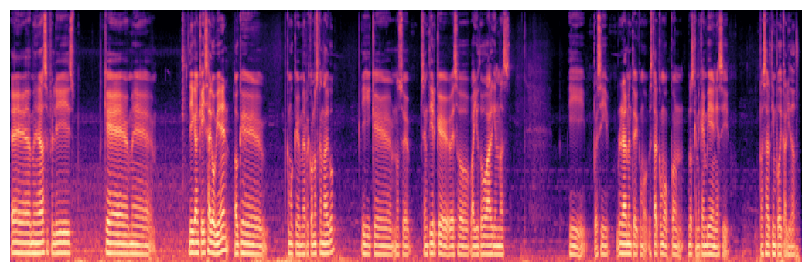

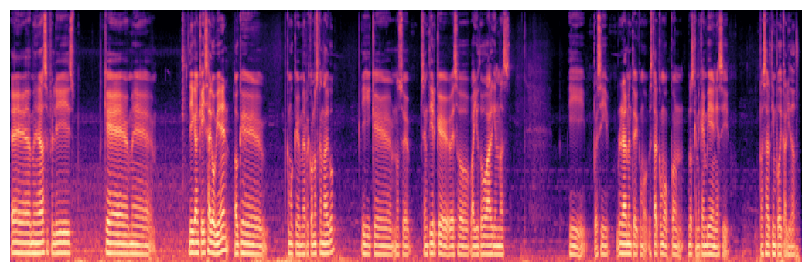

In [22]:
tester = KFoldCNNTester(data_dict_loaded, 'results', batch_size=40, use_tf_data=False, use_complete_model=True, num_channels=1) #32 needs supervision as it stops more

# Run the K-Fold test
tester.run_kfold_test()
